In [113]:
import pandas as pd
import warnings
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import numpy as np

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [114]:
path = "lifeexpectancy_test_sampled.csv"
df = pd.read_csv(path)

In [115]:
X = df.drop('Age at death', axis=1)
y = df['Age at death']

In [116]:
X = sm.add_constant(X)

In [117]:
# Fit the regression model
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Age at death   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     9988.
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:25:55   Log-Likelihood:                -25440.
No. Observations:               10000   AIC:                         5.090e+04
Df Residuals:                    9991   BIC:                         5.096e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [103]:
X_cleaned = X.dropna()
for col in X.columns:
    if X[col].dtype == 'float64' or X[col].dtype == 'int64':
        X[col] = X[col].fillna(X[col].median()) 

In [104]:
# Assuming 'X_cleaned' is your DataFrame without NaNs
X_cleaned = sm.add_constant(X_cleaned)  # Re-adding constant after cleaning

# Calculate VIF for each independent variable again
vif_data_cleaned = pd.DataFrame()
vif_data_cleaned["feature"] = X_cleaned.columns
vif_data_cleaned["VIF"] = [variance_inflation_factor(X_cleaned.values, i) for i in range(len(X_cleaned.columns))]

print(vif_data_cleaned)

                            feature            VIF
0                             const  315988.253686
1                            Gender       1.276099
2       Household income percentile       2.594704
3                     Year of death       1.264884
4                        income lag       4.120672
5                    mortality rate      18.422134
6             mean household income       1.233919
7                   count of deaths      11.899756
8  count alive at beginning of year       3.231750


In [105]:
# Drop 'Age at death' from the dataset
X_modified = X.drop('mortality rate', axis=1)
# Recalculate VIFs for the modified dataset
vif_data_modified = pd.DataFrame()
vif_data_modified["feature"] = X_modified.columns
vif_data_modified["VIF"] = [variance_inflation_factor(X_modified.values, i) for i in range(len(X_modified.columns))]

print(vif_data_modified)

                            feature            VIF
0                             const  307125.803381
1                            Gender       1.258087
2       Household income percentile       2.582223
3                     Year of death       1.231135
4                        income lag       2.512210
5             mean household income       1.233733
6                   count of deaths       4.316907
7  count alive at beginning of year       2.733377


In [106]:
df = df.dropna()
# Separate features and target variable before normalization
X = df.drop(['Age at death', 'mortality rate','mean household income'], axis=1)
y = df['Age at death']

# Optional: Impute missing values if necessary
imputer = SimpleImputer(strategy='median')  # or another strategy that fits your needs
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)  # Convert back to DataFrame

# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_imputed)
X_normalized = pd.DataFrame(X_normalized, columns=X_imputed.columns)  # Convert back to DataFrame

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [107]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

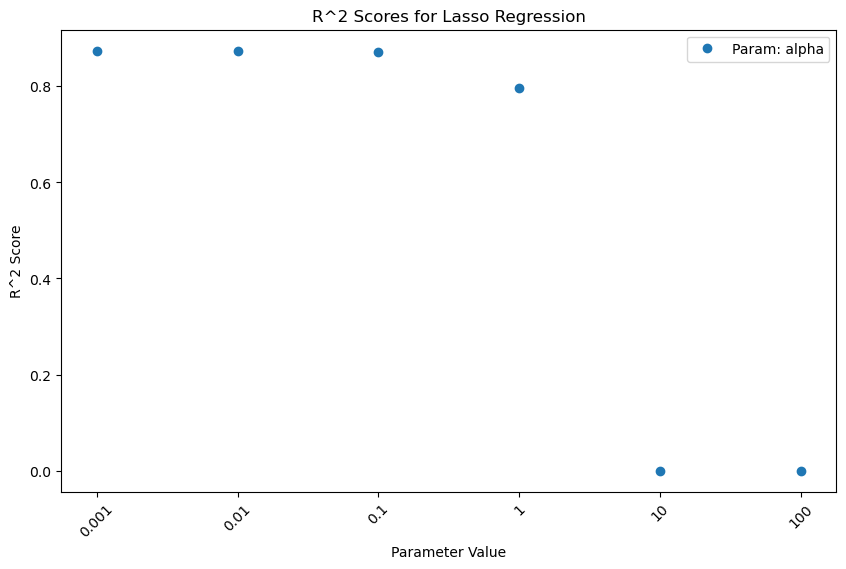

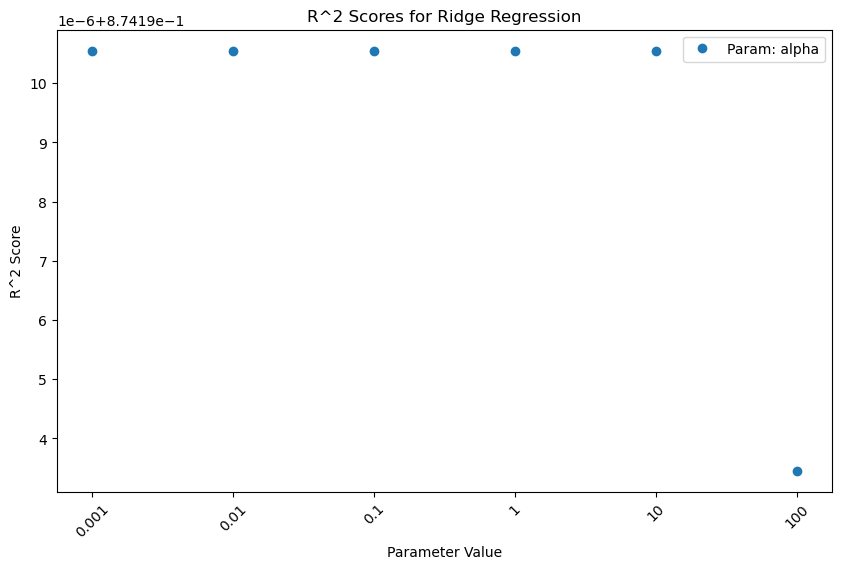

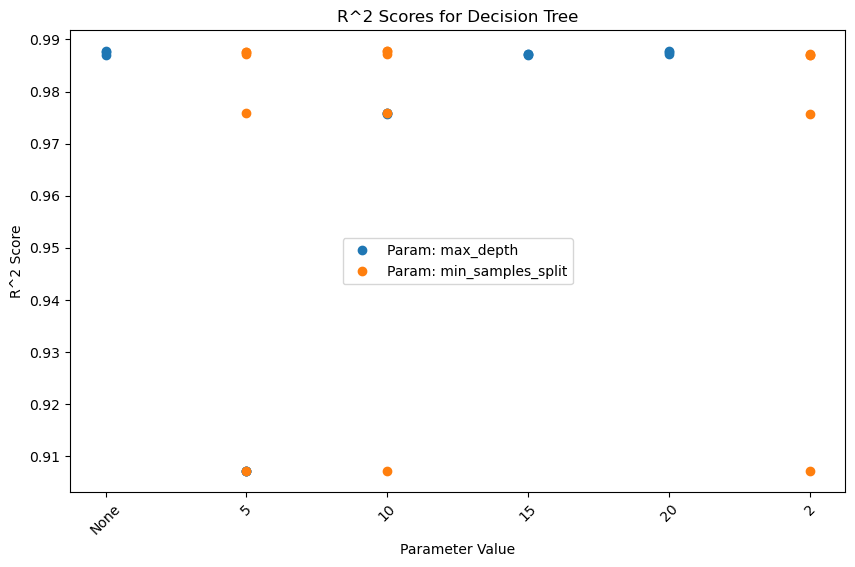

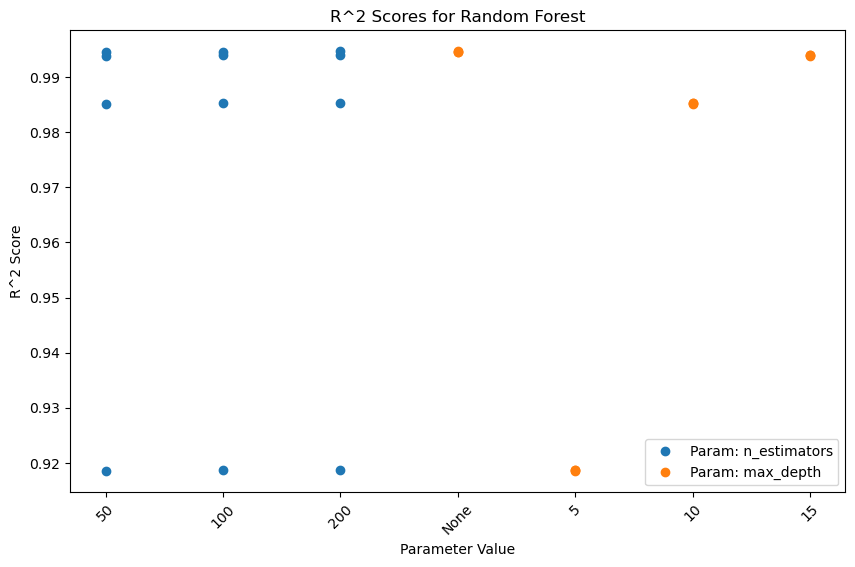

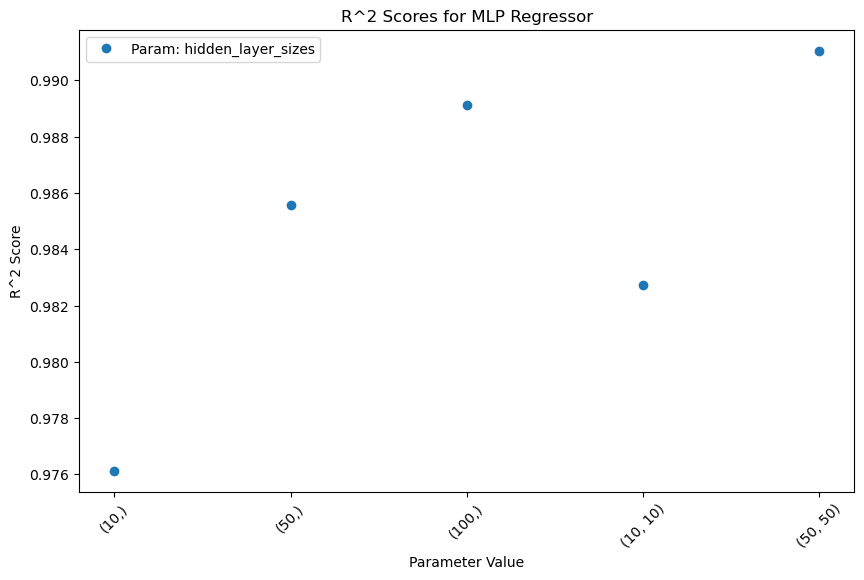

In [118]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(random_state=42),
    "Ridge Regression": Ridge(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(random_state=42, max_iter=10000)
}

# Hyperparameter grids
param_grids = {
    "Lasso Regression": {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    "Ridge Regression": {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    "Decision Tree": {'max_depth': [None, 5, 10, 15, 20], 'min_samples_split': [2, 5, 10]},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 15]},
    "MLP Regressor": {'hidden_layer_sizes': [(10,), (50,), (100,), (10,10), (50,50)]}
}

# Perform hyperparameter tuning and evaluation
results = {}
for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {"MSE": mse, "R^2": r2, "Best Params": grid_search.best_params_}

        # Plotting adjustments for special parameter types
        plt.figure(figsize=(10, 6))
        for param in param_grids[name]:
            try:
                # Attempt to plot assuming values are plot-able as-is
                values = [str(params[param]) for params in grid_search.cv_results_['params']]
                scores = grid_search.cv_results_['mean_test_score']
                if isinstance(values[0], tuple):  # Check if the parameter value is a tuple
                    values = [str(v) for v in values]  # Convert tuples to strings for plotting
                plt.plot(values, scores, 'o', label=f'Param: {param}')
            except Exception as e:
                print(f"Error plotting {param}: {e}")
        plt.title(f'R^2 Scores for {name}')
        plt.xlabel('Parameter Value')
        plt.ylabel('R^2 Score')
        plt.legend()
        plt.xticks(rotation=45) 
        plt.savefig(f'{name}.png')
        plt.show()

In [119]:
print(results)

{'Lasso Regression': {'MSE': 10.777897251157539, 'R^2': 0.8732881137336274, 'Best Params': {'alpha': 0.001}}, 'Ridge Regression': {'MSE': 10.77810490872392, 'R^2': 0.8732856723778304, 'Best Params': {'alpha': 1}}, 'Decision Tree': {'MSE': 0.9717513317627123, 'R^2': 0.9885754668688933, 'Best Params': {'max_depth': 20, 'min_samples_split': 10}}, 'Random Forest': {'MSE': 0.3825164095433256, 'R^2': 0.9955028912735395, 'Best Params': {'max_depth': None, 'n_estimators': 200}}, 'MLP Regressor': {'MSE': 0.6941201973946213, 'R^2': 0.9918394768981479, 'Best Params': {'hidden_layer_sizes': (50, 50)}}}
